# 네이버 영화리뷰 감성분석 도전하기

# 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
%matplotlib inline
import re
from konlpy.tag import Mecab  # konlpy: 한국어 정보처리를 위한 파이썬 패키지
from collections import Counter
from konlpy.tag import Okt
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터 로더 구성
1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(Stopwords) 제거
5. 사전word_to_index 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. x_train, y_train, x_test, y_test, word_to_index 리턴

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)
    
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(x_train), len(x_test)))

index_to_word = {index:word for word, index in word_to_index.items()}

train data 개수: 146182, test data 개수: 49157


In [3]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공

In [4]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [5]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


# 4. validation set구성 및 모델 훈련

In [6]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지를 훈련 데이터로
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [7]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수(변경 가능한 하이퍼파라미터)

### RNN(LSTM)

In [8]:
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 모델 훈련
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 9s 7ms/step - loss: 0.4747 - accuracy: 0.7888 - val_loss: 0.3509 - val_accuracy: 0.8501
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3327 - accuracy: 0.8598 - val_loss: 0.3360 - val_accuracy: 0.8526
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3101 - accuracy: 0.8696 - val_loss: 0.3400 - val_accuracy: 0.8529
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2953 - accuracy: 0.8775 - val_loss: 0.3391 - val_accuracy: 0.8525
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2825 - accuracy: 0.8827 - val_loss: 0.3407 - val_accuracy: 0.8525


In [10]:
results = model_rnn.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3522 - accuracy: 0.8478
[0.35219141840934753, 0.84775310754776]


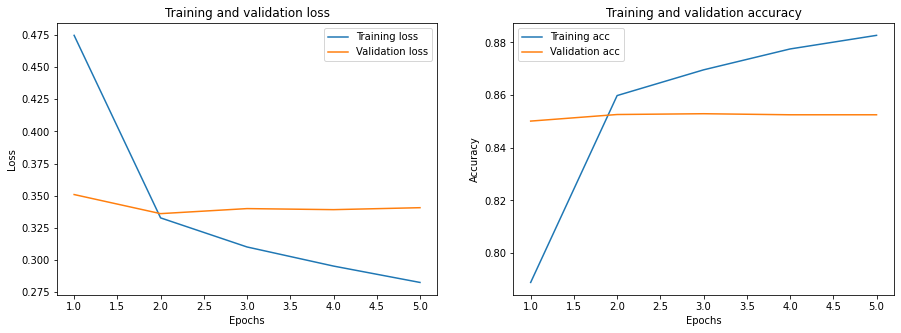

In [11]:
# Loss, Accuracy 그래프 시각화
history_rnn_dict = history_rnn.history

acc = history_rnn_dict['accuracy']
val_acc = history_rnn_dict['val_accuracy']
loss = history_rnn_dict['loss']
val_loss = history_rnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss') 
plt.plot(epochs, val_loss, label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training acc') 
plt.plot(epochs, val_acc, label='Validation acc') 
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN

In [12]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
# 모델 훈련
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
266/266 [==============================] - 5s 6ms/step - loss: 0.4861 - accuracy: 0.7607 - val_loss: 0.3475 - val_accuracy: 0.8492
Epoch 2/4
266/266 [==============================] - 1s 4ms/step - loss: 0.3249 - accuracy: 0.8617 - val_loss: 0.3333 - val_accuracy: 0.8555
Epoch 3/4
266/266 [==============================] - 1s 4ms/step - loss: 0.2899 - accuracy: 0.8789 - val_loss: 0.3315 - val_accuracy: 0.8583
Epoch 4/4
266/266 [==============================] - 1s 5ms/step - loss: 0.2600 - accuracy: 0.8951 - val_loss: 0.3356 - val_accuracy: 0.8553


In [14]:
results = model_cnn.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3507 - accuracy: 0.8523
[0.3507239818572998, 0.8523099422454834]


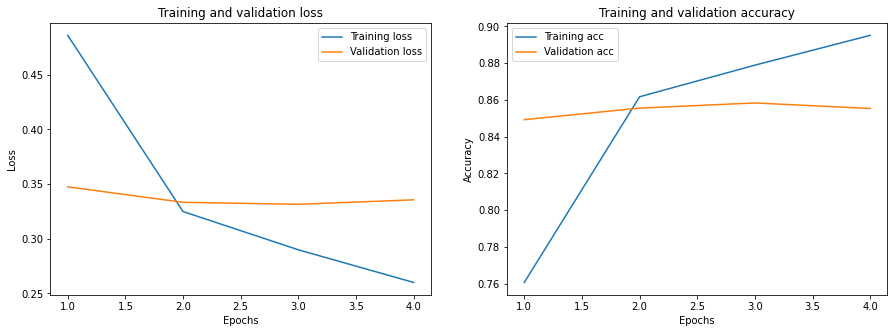

In [15]:
# Loss, Accuracy 그래프 시각화
history_cnn_dict = history_cnn.history

acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss') 
plt.plot(epochs, val_loss, label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc') 
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D

In [16]:
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 모델 훈련
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 1s 4ms/step - loss: 0.5746 - accuracy: 0.7620 - val_loss: 0.4126 - val_accuracy: 0.8282
Epoch 2/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3688 - accuracy: 0.8434 - val_loss: 0.3526 - val_accuracy: 0.8446
Epoch 3/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3204 - accuracy: 0.8654 - val_loss: 0.3446 - val_accuracy: 0.8478
Epoch 4/5
266/266 [==============================] - 1s 3ms/step - loss: 0.2942 - accuracy: 0.8786 - val_loss: 0.3466 - val_accuracy: 0.8498
Epoch 5/5
266/266 [==============================] - 1s 3ms/step - loss: 0.2747 - accuracy: 0.8880 - val_loss: 0.3510 - val_accuracy: 0.8504


In [18]:
results = model_gmp.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3622 - accuracy: 0.8454
[0.3621639013290405, 0.8453526496887207]


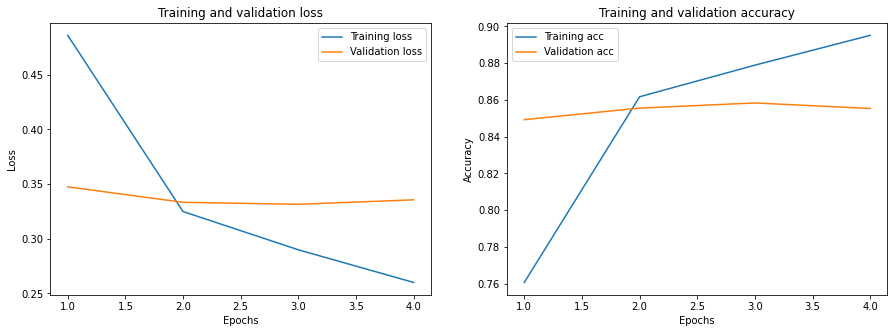

In [19]:
# Loss, Accuracy 그래프 시각화
history_gmp_dict = history_cnn.history

acc = history_gmp_dict['accuracy']
val_acc = history_gmp_dict['val_accuracy']
loss = history_gmp_dict['loss']
val_loss = history_gmp_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss') 
plt.plot(epochs, val_loss, label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training acc') 
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 5. 학습된 Embedding 레이어 분석

In [20]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [21]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('느꼈', 0.9655967354774475),
 ('천사', 0.9654133915901184),
 ('짐캐리', 0.9618590474128723),
 ('좋아해서', 0.9574822783470154),
 ('마력', 0.9546366333961487),
 ('대작', 0.9538687467575073),
 ('울리', 0.9536306858062744),
 ('am', 0.9530408382415771),
 ('날아가', 0.9525892734527588),
 ('훈', 0.949663519859314)]

In [23]:
word_vectors.similar_by_word("최고")

[('구할', 0.9889545440673828),
 ('소장', 0.9888388514518738),
 ('먹먹', 0.9885464906692505),
 ('이제서야', 0.9866201281547546),
 ('완소', 0.9848740100860596),
 ('흥미진진', 0.983917236328125),
 ('한꺼번에', 0.9813451766967773),
 ('*^^*', 0.9812065362930298),
 ('정점', 0.979366660118103),
 ('사악', 0.9782102108001709)]

* 기존의 Word2Vec으로는 키워드와 비슷한 의미의 단어를 찾기 어려운 것을 알 수 있다. 그러므로 한국어 버전의 Word2Vec을 적용해본다.

# 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선

* https://github.com/Kyubyong/wordvectors 에서 한국어 word2Vec을 다운받아 사용
* gensim4.1.2버전에서 한국어 Word2Vec 파일을 불러오지 못해서 3.8.3버전으로 재설치 후 커널 재시작하였다.

In [25]:
gensim.__version__

'3.8.3'

In [32]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
word2vec.similar_by_word("사랑")

/tmp/ipykernel_206/2173066347.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [33]:
word2vec.similar_by_word("최고")

/tmp/ipykernel_206/3233348575.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("최고")


[('최대', 0.5721614360809326),
 ('최강', 0.5064552426338196),
 ('유일한', 0.46688494086265564),
 ('일류', 0.46184951066970825),
 ('최악', 0.4529539942741394),
 ('최연소', 0.45037323236465454),
 ('랭킹', 0.4485436677932739),
 ('제일의', 0.44647401571273804),
 ('최초', 0.44505739212036133),
 ('최상', 0.4345606565475464)]

단어의 의미가 좀 더 비슷해진 것을 확인했다.

## 모델 다시 학습

In [34]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_206/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_206/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### LSTM

In [60]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))  
model.add(keras.layers.LSTM(32)) 
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,030,097
Trainable params: 2,030,097
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 3s 8ms/step - loss: 0.4706 - accuracy: 0.7701 - val_loss: 0.3639 - val_accuracy: 0.8375
Epoch 2/5
266/266 [==============================] - 2s 7ms/step - loss: 0.3433 - accuracy: 0.8517 - val_loss: 0.3352 - val_accuracy: 0.8531
Epoch 3/5
266/266 [==============================] - 2s 7ms/step - loss: 0.3042 - accuracy: 0.8726 - val_loss: 0.3232 - val_accuracy: 0.8609
Epoch 4/5
266/266 [==============================] - 2s 7ms/step - loss: 0.2790 - accuracy: 0.8845 - val_loss: 0.3264 - val_accuracy: 0.8599
Epoch 5/5
266/266 [==============================] - 2s 7ms/step - loss: 0.2595 - accuracy: 0.8942 - val_loss: 0.3277 - val_accuracy: 0.8625


In [62]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3423 - accuracy: 0.8563
[0.3423008918762207, 0.85627681016922]


### CNN

In [77]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_27 (Dense)             (None, 1)               

In [78]:
model.compile(optimizer='Adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
epochs=4
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
2128/2128 [==============================] - 10s 5ms/step - loss: 0.4393 - accuracy: 0.7905 - val_loss: 0.3565 - val_accuracy: 0.8453
Epoch 2/4
2128/2128 [==============================] - 10s 4ms/step - loss: 0.3238 - accuracy: 0.8616 - val_loss: 0.3304 - val_accuracy: 0.8560
Epoch 3/4
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2871 - accuracy: 0.8802 - val_loss: 0.3234 - val_accuracy: 0.8613
Epoch 4/4
2128/2128 [==============================] - 9s 4ms/step - loss: 0.2575 - accuracy: 0.8950 - val_loss: 0.3306 - val_accuracy: 0.8605


In [79]:
results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3493 - accuracy: 0.8538
[0.3493459224700928, 0.8538356423377991]


### GlobalMaxPooling1D

In [102]:
model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 200)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.compile(optimizer='Adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
epochs=10
history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=16,
                        validation_data=(x_val, y_val),
                        verbose=1)

Epoch 1/10
8512/8512 [==============================] - 28s 3ms/step - loss: 0.4996 - accuracy: 0.7474 - val_loss: 0.4174 - val_accuracy: 0.8089
Epoch 2/10
8512/8512 [==============================] - 27s 3ms/step - loss: 0.3850 - accuracy: 0.8271 - val_loss: 0.3808 - val_accuracy: 0.8304
Epoch 3/10
8512/8512 [==============================] - 27s 3ms/step - loss: 0.3406 - accuracy: 0.8519 - val_loss: 0.3720 - val_accuracy: 0.8348
Epoch 4/10
8512/8512 [==============================] - 28s 3ms/step - loss: 0.3093 - accuracy: 0.8691 - val_loss: 0.3708 - val_accuracy: 0.8346
Epoch 5/10
8512/8512 [==============================] - 28s 3ms/step - loss: 0.2829 - accuracy: 0.8824 - val_loss: 0.3660 - val_accuracy: 0.8406
Epoch 6/10
8512/8512 [==============================] - 28s 3ms/step - loss: 0.2608 - accuracy: 0.8946 - val_loss: 0.3757 - val_accuracy: 0.8409
Epoch 7/10
8512/8512 [==============================] - 28s 3ms/step - loss: 0.2402 - accuracy: 0.9043 - val_loss: 0.3874 - val_ac

In [104]:
results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4446 - accuracy: 0.8307
[0.4446064233779907, 0.8306649923324585]


# 회고
훈련시킨 3가지 모델의 한국어 Word2Vec 임베딩 전후 accuracy를 살펴보면
1. LSTM : 적용 전 0.8478 / 후 0.8563
2. CNN : 적용 전 0.8523 / 후 0.8538
3. GMP : 적용 전 0.8454 / 후 0.8307

* LSTM과 CNN모델은 성능이 소폭 향상되어 루브릭 평가기준인 accuracy 85%를 달성하였다. 하지만 GlobalMaxPooling1D모델은 오히려 성능이 감소하였다. epoch와 barch_size 등을 바꿔가면서 여러번 시도하였으나 GlobalMaxPooling1D 모델의 accuracy를 올리는 것이 쉽지 않았다. 자연어 감정 평가 모델로는 적합하지 않은 것 같다.
* 프로젝트를 진행하며 많은 시행착오가 있었지만 검색하고 질문하며 해결해내고 나니 보람이 느껴졌고 실력이 느는 과정이라는 생각을 했다. 이미지 처리와 자연어 처리 둘 다 쉽지 않았지만 어느 정도 윤곽이 잡힌 느낌이라 앞으로가 더욱 기대된다. 